In [3]:
import sympy as sym
sym.init_printing()

In [97]:
import random
import numpy as np

In [257]:
from sympy import oo

In [189]:
import matplotlib.pyplot as plt
%matplotlib inline

In [259]:
r, t, k, i = sym.symbols('r, t, k, i')

Math checks for me
------------------

In [156]:
rhs = (r - 1) ** 2
lhs = (1 - r) ** 2

In [157]:
rhs.expand() == lhs.expand()

True

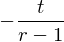

In [188]:
((1 - r) * t / (r - 1) ** 2).simplify()

In [254]:
((r * t - 1) ** 2).expand()

First formulation (without t)
-------------------


In [264]:
selective = 1 / (1 - r)

In [286]:
indiscriminate = ((1 - r) * sym.summation(i * r ** (i - 1), (i, 1, k)))

In [287]:
last_turn = (k + 1) * r ** k

In [288]:
indiscriminate += last_turn

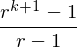

In [289]:
indiscriminate.simplify()

It can be seen that indiscriminate cost is always less with this formulation.

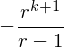

In [290]:
(selective - indiscriminate.simplify()).simplify() 

Because $\frac{r^{k + 1}}{1 - r}$ is always positive and non negative.

Selective (with t)
---------

For selective the model is simple. At each time step there is a $(1 - r)$ probability to get a rhino. If a selective gets a rhino then they need $t$ time to take the horn.

In [291]:
def selective_risk(r, t):
    return t / (1 - r)

In [292]:
selective_risk(0.5, 5), selective_risk(0.7, 5), selective_risk(0.3, 5)

In [273]:
def selective_risk_simulation(r, t):
    N = 1
    s = [1 - r]
    while random.random() < (1 - r):
        N += 1
        s.append(N * r ** (N - 1) * (1 - r))
    
    return t * sum(s)

In [274]:
xs = range(1000)
ys = []
for _ in xs:
    ys.append(selective_risk_simulation(0.5, 5))

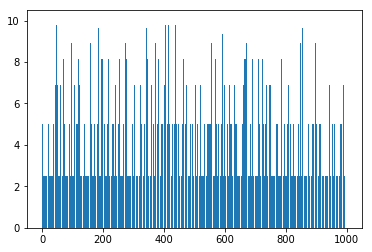

In [275]:
plt.bar(xs, ys);

In [276]:
np.mean(ys), np.max(ys)

Indiscriminate (with t)
-----------------------

Indisciminate cost: 
    
$$t (1 - r) \sum_{i=1}^{k} i r ^{(i -1)} t ^{(i -1)} + (k + 1) r ^ k$$ 

where $$k = \frac{1}{\theta_r} - 1$$

In [317]:
indiscriminate = (t * (1 - r) * sym.summation(i * r ** (i - 1) * t ** (i - 1), (i, 1, k)))

In [318]:
indiscriminate += last_turn

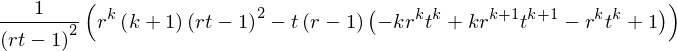

In [319]:
indiscriminate.simplify()

In [311]:
indiscriminate.subs({r: 1}).simplify()

In [313]:
indiscriminate.subs({r: 0, k:0}).simplify()

In [322]:
def indiscriminate_risk_simulation(r, t, theta_r):
    N = 1
    s = [1 - r]
    while random.random() < (1 - r):
        N += 1
        s.append(N * r ** (N - 1) * (1 - r) * t **(N - 1))
        
        if theta_r * N > 1:
            return N * r ** (N - 1) * t ** (N - 1)
    
    return t * sum(s)